* 사전 설치
  * python 3 와 python 패키지 - pandas, matplotlib, numpy, scipy, ipykernel, openpyxl
  * visual studio code와 visual studio code 확장 - python, pylance, jupyter
  * KoPubWorld 글꼴
* 본 교육자료 다운로드: https://github.com/seongchong/pr_lecture
* 문의처: 박성종 spark@kriss.re.kr

In [1]:
# 패키지 불러오기
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

# matplotlib 글꼴 및 그림 해상도 설정
plt.style.use("default")
plt.rcParams["font.family"] = "KoPubWorldDotum"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["figure.dpi"] = 100

# 상수 정의
pi = np.pi  # 원주율
c = 2.99792e8  # 진공 중 빛의 속력

# 광측정(光測定, photometry)
* 넓은 의미의 광측정 (optical measurement)
  * `광학적 복사선(輻射線)` 전체를 대상으로 하는 모든 종류의 측정
* 좁은 의미의 광측정 (photometry)
  * `전체 광학적 복사선` 중 `가시광선`을 주 대상으로 하고, `인간의 시감`을 고려한 `밝기`에 관한 측정
  * `광학적 복사선`에 대한 `복사측정`(optical radiometry)의 일부
* 복사측정 (optical radiometry)
  * `광학적 복사선`의 `일률`(복사선속, 단위:W) 및 그 파생량을 여러 `기하학적 조건`에서 측정하는 것을 가리킴.
  * 전력, (광)출력, 일률, 복사선속은 모두 W 단위임에 주의할 것.

## 광학적 복사선의 분류
|이름|파장범위|이름|파장범위|
|:---:|:---:|:---:|:---:|
|EUV |10 nm ~ 121 nm|NIR 근적외선| 780 nm ~ 1.4 μm|
|UV-C |100 nm ~ 280 nm|SWIR 단파적외선 |1.4 μm ~ 3 μm|
|UV-B|280 nm ~ 315 nm|MWIR 중파적외선| 3 μm ~ 8 μm|
|UV-A|315 nm ~ 400 nm|LWIR 장파적외선| 8 μm ~ 15 μm|
|`가시광선`|380 nm ~ 780 nm|FIR 원적외선| 15 μm ~ 1000 μm|

## 칸델라(광도의 단위)의 정의
>칸델라(기호: cd)는 어떤 주어진 방향에서 광도의 SI 단위이다. 칸델라는 주파수가 540 × 10<sup>12</sup> Hz인 단색광의 시감효능 _K_<sub>cd</sub>를 lm W<sup>–1</sup> 단위로 나타낼 때 그 수치를 683으로 고정함으로써 정의한다. 여기서 lm W<sup>–1</sup>은 cd sr W<sup>-1</sup> 또는 cd sr kg<sup>–1</sup> m<sup>–2</sup> s<sup>3</sup>과 같고, 킬로그램(기호: kg), 미터(기호: m)와 초(기호: s)는 _h_, _c_ 와 Δν<sub>Cs</sub>로부터 정의된다.

In [2]:
# 연습 문제: 주파수가 540 THz인 단색광의 진공 중 파장은 얼마인가?

# 빛의 주파수, 빛의 속도
주파수 = 540e12  # 단위: Hz
# 빛의 파장
파장 = c / 주파수  # 단위: m
# 결과 출력
print(
    f"주파수 {주파수 * 1E-12:4.1f} THz의 빛은 \
진공 중에서 파장이 {파장 * 1E9:6.2f} nm 이다."
)

주파수 540.0 THz의 빛은 진공 중에서 파장이 555.17 nm 이다.


* 즉, 555.17 nm 의 빛 1 W 의 복사선속이 광선속 683 lm 에 해당하는 것으로 정의됨.
  * 555 nm의 빛 1 W 의 복사선속은 683.002 lm에 해당함 ($K_m = 683.002~\textrm{lm/W}$)

## 파장의 함수인 인간의 시감 효율
* 밝은 빛에 대한 시감 (10 cd/m<sup>2</sup> ~ 10<sup>8</sup> cd/m<sup>2</sup>)
  * 555 nm에서 최대 효능 $K_m = 683~\textrm{lm/W}$을 갖고, $K_m V(\lambda)$로 표현됨.
* 어두운 빛에 대한 시감 (10<sup>-6</sup> cd/m<sup>2</sup> ~ 10<sup>-3</sup> cd/m<sup>2</sup>)
  * 507 nm에서 최대 효능 $K'_m = 1700~\textrm{lm/W}$을 갖고,  $K'_m V'(\lambda)$로 표현됨.

※ $V(\lambda)$과 $V'(\lambda)$ 각각은 국제조명위원회가 정한 각각 밝은 빛, 어두운 빛에 대한 상대 분광시감효율 함수임.

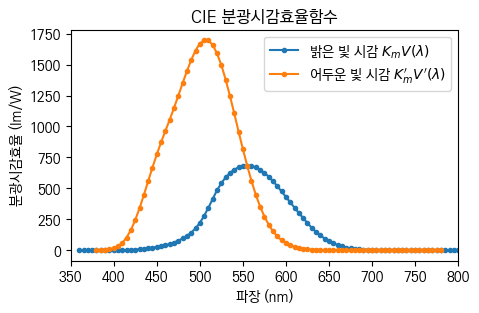

In [3]:
# 표준 관측자의 분광시감효율

# 밝은 빛 시감의 상대분광시감효율 V(λ)를 불러오기
d0 = pd.read_excel(
    "CIE_data.xlsx",
    sheet_name="CIE_V_lambda",
    index_col=0,
    usecols=[0, 1],
    names=["w", "V"],
)
# 밝은 빛 시감의 최대 분광 시감 효율
K_m = 683.0  # 단위: lm/W
# 밝은 빛 시감 분광시감효율 플롯팅
(K_m * d0.V).plot(marker=".")
# V(λ) 내삽 함수 정의
f_V = interp1d(d0.index, d0.V, fill_value=0, bounds_error=False, kind="cubic")
# 어두운 빛 시감의 상대분광시감효율 V'(λ)를 불러오기
d1 = pd.read_excel(
    "CIE_data.xlsx",
    sheet_name="CIE_V_prime_lambda",
    index_col=0,
    usecols=[0, 1],
    names=["w", "V"],
)
# 어두운 빛 시감의 최대 분광 시감 효율
K_m_prime = 1700.0  # 단위: lm/W
# 밝은 빛 시감 분광시감효율 플롯팅
(K_m_prime * d1.V).plot(
    figsize=(5, 3),
    xlim=(350, 800),
    xlabel="파장 (nm)",
    ylabel="분광시감효율 (lm/W)",
    title="CIE 분광시감효율함수",
    marker=".",
)
# V'(λ) 내삽 함수 정의
f_V_prime = interp1d(d1.index, d1.V, fill_value=0, bounds_error=False, kind="cubic")
# 범례 표시
plt.legend(
    [r"밝은 빛 시감 $K_m V(\lambda)$", r"어두운 빛 시감 $K_m^\prime V^\prime(\lambda)$"]
)
plt.show()

In [4]:
# 연습문제: 475 nm의 빛 0.1 mW은 밝은 빛 시감 기준과 어두운 시감 기준으로
# 각각 몇 lm 인가?

파장 = 475  # 475 nm
복사선속 = 0.1e-3  # 0.1 mW
밝은빛 = K_m * f_V(475) * 복사선속
어두운빛 = K_m_prime * f_V_prime(475) * 복사선속
print(
    f"파장 {파장} nm 의 {복사선속:4.2e} W 은 밝은 빛 시감으로 \
{밝은빛:4.2e} lm,\n어두운 빛 시감으로 {어두운빛:4.2e} lm 이다."
)

파장 475 nm 의 1.00e-04 W 은 밝은 빛 시감으로 7.69e-03 lm,
어두운 빛 시감으로 1.25e-01 lm 이다.


## 분광복사측정량, 복사측정량, 광측정량 사이의 관계
임의의 분광복사측정량 $S(\lambda)$에 대해

* 복사측정량: $S(\lambda)$의 $\lambda$ 에 관한 적분
$$S_e = \int_{380~\textrm{nm}}^{780~\textrm{nm}} S(\lambda) d\lambda$$ 
  
* 광측정량: $S(\lambda)$를 $V(\lambda)$로 가중한 $\lambda$ 에 관한 적분
$$S_v = K_m \int_{380~\textrm{nm}}^{780~\textrm{nm}} S(\lambda) V(\lambda) d\lambda$$

* 관례적으로 첨자 $e$는 복사측정량을, 첨자 $v$는 광측정량을, 첨자가 없으면 분광복사측정량을 의미함.
* 분광복사측정량은 기하학적인 조건에 따라,
  * 분광복사선속 (W nm<sup>-1</sup>), 분광복사도(W sr<sup>-1</sup> nm<sup>-1</sup>), 분광복사휘도 (W m<sup>-2</sup> sr<sup>-1</sup> nm<sup>-1</sup>), 분광복사조도 (W m<sup>-2</sup> nm<sup>-1</sup>) 등

0 - 광원: LED_R, 복사측정량: 99.98, 광측정량: 17764.44


1 - 광원: LED_G, 복사측정량: 99.99, 광측정량: 55896.05
2 - 광원: LED_B, 복사측정량: 99.87, 광측정량: 5085.30


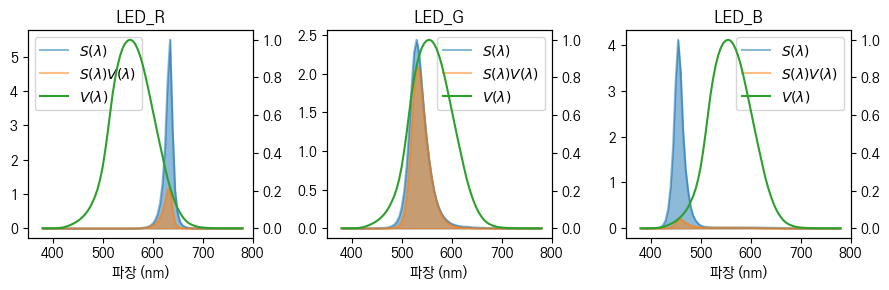

In [5]:
# LED R/G/B에 대한 복사측정량과 광측정량 계산

# 스펙트럼 데이터 불러오기
d2 = pd.read_excel("CIE_data.xlsx", sheet_name="SPD", index_col=0)
# 편의상 모두 복사선속이 100 W가 되도록 정규화 함.
d2 = d2 / d2.sum() * 100
# 파장 데이터 정의
dw = 5  # 파장간격 5 nm
# 파장 배열: 380, 385, ..., 780
w = np.arange(380, 780 + dw, dw)
# 상대분광시감효율 V(λ)
V = d0.V[w]
# 그래프 설정
fig, axes = plt.subplots(nrows=1, ncols=3)
for idx, S in enumerate([d2.LED_R[w], d2.LED_G[w], d2.LED_B[w]]):
    # S(λ) 플롯
    S.plot(ax=axes[idx], kind="area", stacked=False)
    # S(λ)V(λ) 플롯
    (S * V).plot(ax=axes[idx], secondary_y=False, kind="area", stacked=False)
    # V(λ) 플롯
    V.plot(
        ax=axes[idx],
        figsize=(9, 3),
        xlim=(350, 800),
        xlabel="파장 (nm)",
        secondary_y=True,
    )
    # 범례 표시
    lines = axes[idx].get_lines() + axes[idx].right_ax.get_lines()
    axes[idx].legend(
        lines, [r"$S(\lambda)$", r"$S(\lambda)V(\lambda)$", r"$V(\lambda)$"]
    )
    # 제목표시
    axes[idx].set_title(S.name)
    # 광측정량 계산
    f_e = S.sum() * dw
    # 복사측정량 계산
    f_v = (S * V).sum() * dw * K_m
    # 광측정량, 복사측정량 출력
    print(
        f"{idx} - 광원: {S.name}, \
복사측정량: {f_e:4.2f}, 광측정량: {f_v:4.2f}"
    )
plt.tight_layout()
plt.show()

## 복사선속과 광선속
* 복사선속 (radiant flux)
  * 광학적 일률(W = J/s)의 다른 이름으로 단위시간 당 전달되는 광학적 복사에너지를 나타냄.  
  * 복사선속에 기하학적 조건이 부여됨에 따라 복사조도, 복사도, 복사휘도, 전복사선속 등이 파생됨.
  * 관례적으로 기호 $\Phi_e$로 나타냄 (첨자가 없는 $\Phi$는 분광복사선속을 나타냄)
* 광선속 (luminous flux)
  * 복사선속에 대응되는 광측정량으로 단위시간 당 전달되는 밝기 자극을 나타냄.
  * 광선속에 기하학적 조건이 부여됨에 따라 광조도, 광도, 광휘도, 전광선속 등이 파생됨.
  * 관례적으로 관례적으로 기호 $\Phi_v$로 나타냄.

## 광조도 (illuminance)
* `어떤 위치`의 단위면적으로 입사하는 광선속 (단위: lm/m<sup>2</sup>, lx)
$$E_v = {d\Phi_v \over dA}$$ 
<img src="그림_광조도의_기하학적_조건.png" width="400px" title="광조도의 기하학적 조건" alt="광조도의 기하학적 조건"></img>
* 광원의 특성이 아니기 때문에 광도, 광휘도, 전광선속과 같은 불변량이 아님.
* 검출기 기반 표준 소급체계 (단위유도 체계)에서 가장 근간이 되는 측정량임. 

In [6]:
# 연습문제: 직경 1 cm의 원형 센서 633 nm의 빛 1 mW 가 입사되고 있을 때의
# 센서면에서의 광조도는?

파장 = 633  # 633 nm
복사선속 = 1e-3  # 1 mW
광선속 = K_m * f_V(633) * 복사선속
직경 = 1e-2  # 1 cm
면적 = pi * (직경 / 2) ** 2
광조도 = 광선속 / 면적
print(f"광조도 =  {광조도:4.2e} lx")

광조도 =  2.05e+03 lx


## 광조도의 코사인 (cosine) 응답성
$$E_\theta = E_0 \cos\theta$$
<img src="그림_광조도의_코사인_응답성.png" width="400px" title="광조도의 코사인 응답성" alt="광조도의 코사인 응답성"></img>

* 입사광과 측정면의 법선이 이루는 각에 따라서 광조도 값은 $\cos\theta$를 따름.
* 그러나 실제 광조도 센서는 이러한 코사인 응답성을 거의 보장하지 못함 (Fresnel 반사 효과 등으로 인해) 
  * 확산판과 적분구 등을 이용하여 코사인 응답성을 근사적으로 구현할 수 있음.

In [7]:
# 연습문제: 수직면에서 100 lx의 광조도를 형성했다면
# 수직에서 30°만큼 기울어진 면에서의 형성되는 광조도는?

광조도_0 = 100  # 100 lx
입사각 = 30 * pi / 180  # 30°의 래디안 값
광조도_30 = 100 * np.cos(입사각)
print(f"30°에서의 광조도 {광조도_30:3.1f} lx")

30°에서의 광조도 86.6 lx


## 프레넬 (Fresnel) 반사 공식 
* 굴절율이 다른 두 매질의 경계에서 일어나는 빛의 반사를 기술함.
* s-편광과 p-편광에 대해, 입사각과 굴절율에 따른 반사율은
$$ R_s = \left| {n_i \cos\theta_i - n_t \cos\theta_t \over n_i \cos\theta_i + n_t \cos\theta_t} \right|^2,~R_p = \left| {n_t \cos\theta_i - n_i \cos\theta_t \over n_t \cos\theta_i + n_i \cos\theta_t} \right|^2$$
* 여기서, $\theta_i$와 $\theta_t$는 스넬 (Snell)의 법칙에 따라
$$n_i \sin\theta_i = n_t \sin\theta_t$$
* $n_i$와 $n_t$는 복소수 굴절율로 일반화될 수 있음.

In [8]:
# 연습문제: 공기와 색필터의 굴절율이 각각 1.00, 1.54+0.91j (500 nm) 일 때,
# 경계면에서의 입사각 0° ~ 90°의 반사율은?


# 프레넬 반사율 계산 함수 정의
def fresnel_reflectance(x_i, n_i, n_t):
    x_t = np.arcsin(n_i * np.sin(x_i) / n_t)
    # s 편광의 Fresnel 반사계수
    r_s = (n_i * np.cos(x_i) - n_t * np.cos(x_t)) / (
        n_i * np.cos(x_i) + n_t * np.cos(x_t)
    )
    # p 편광의 Fresnel 반사계수
    r_p = (n_t * np.cos(x_i) - n_i * np.cos(x_t)) / (
        n_t * np.cos(x_i) + n_i * np.cos(x_t)
    )
    # s 편광의 Fresnel 반사율
    R_s = np.real(np.conj(r_s) * r_s)
    # p 편광의 Fresnel 반사율
    R_p = np.real(np.conj(r_p) * r_p)
    return R_s, R_p


n_i = 1.00  # 공기의 굴절율
n_t = 1.54 + 0.91j  # 색필터의 굴절율 (HOYA G533)
for ang in range(0, 90 + 15, 15):
    x_i = ang * pi / 180  # degree -> radian
    R_s, R_p = fresnel_reflectance(x_i, n_i, n_t)
    print(
        f"{ang:2d}°: s-편광 반사율 {R_s:5.3f}, \
p-편광 반사율 {R_p:5.3f}, 평균 반사율 {(R_p + R_s)/2:5.3f}"
    )

 0°: s-편광 반사율 0.154, p-편광 반사율 0.154, 평균 반사율 0.154
15°: s-편광 반사율 0.164, p-편광 반사율 0.144, 평균 반사율 0.154
30°: s-편광 반사율 0.199, p-편광 반사율 0.114, 평균 반사율 0.157
45°: s-편광 반사율 0.270, p-편광 반사율 0.073, 평균 반사율 0.171
60°: s-편광 반사율 0.398, p-편광 반사율 0.046, 평균 반사율 0.222
75°: s-편광 반사율 0.623, p-편광 반사율 0.156, 평균 반사율 0.389
90°: s-편광 반사율 1.000, p-편광 반사율 1.000, 평균 반사율 1.000


In [9]:
# 연습문제: 공기와 Si의 굴절율이 각각 1.00, 4.32 (500 nm) 일 때,
# 경계면에서의 입사각 0° ~ 90°의 반사율은?

n_i = 1.00  # 공기의 굴절율
n_t = 4.32  # Si의 굴절율
for ang in range(0, 90 + 15, 15):
    x_i = ang * pi / 180
    R_s, R_p = fresnel_reflectance(x_i, n_i, n_t)
    print(
        f"{ang:2d}°: s-편광 반사율 {R_s:5.3f}, \
p-편광 반사율 {R_p:5.3f}, 평균 반사율 {(R_p + R_s)/2:5.3f}"
    )

 0°: s-편광 반사율 0.389, p-편광 반사율 0.389, 평균 반사율 0.389
15°: s-편광 반사율 0.402, p-편광 반사율 0.377, 평균 반사율 0.389
30°: s-편광 반사율 0.441, p-편광 반사율 0.337, 평균 반사율 0.389
45°: s-편광 반사율 0.512, p-편광 반사율 0.262, 평균 반사율 0.387
60°: s-편광 반사율 0.622, p-편광 반사율 0.141, 평균 반사율 0.382
75°: s-편광 반사율 0.782, p-편광 반사율 0.005, 평균 반사율 0.393
90°: s-편광 반사율 1.000, p-편광 반사율 1.000, 평균 반사율 1.000


## 일반적인 광조도 센서의 구성
* 코사인 응답기 (확산판 이나 적분구) + $V(\lambda)$ 정합필터 (색유리나 다층박막) + Si 광 다이오드
* 코사인 응답기가 없는 경우도 있음. 
  * 광도(luminous intensity)를 측정하기 위한 장치에 사용될 경우
  * 그 외의 경우, 코사인 응답기가 없으면 매우 큰 광조도 측정오차가 발생함 (왜? 대부분의 경우 확산 조명이므로).
* 코사인 응답기의 영향
  * 광조도 기준면이 모호해짐.
    * 광도 표준전구와 같이 광원 기준면이 알려진 광원으로 광조도계의 기준면을 알아낼 수 있음.
  * 광조도계 교정 시 엄격한 잡광 관리가 필요로 함.

<img src="그림_광조도계의_각도_응답.png" width="400px" title="광조도계의 각도 응답" alt="광조도계의 각도 응답"></img>

## 광조도 측정 시 유의 사항
* 측정면을 광조도계의 기준면에 일치시킴 (위치 및 각도 정렬 필요)
* 광원에 너무 가까지 붙지 않는 것이 좋음 (반사 효과의 회피)
* 차광판 등을 적절히 활용하여 잡광을 차단시킴.
* 간접 조명과 같은 확산광의 측정 시 반드시 코사인 응답기가 있는 광조도계를 사용해야함.

## 광도 (luminous intensity)
* `광원`이 (지정된 방향의) 단위 입체각으로 발산하는 광선속 (단위: lm/sr, cd)
$$ I_v = {d\Phi_v \over d\Omega} $$
<img src="그림_광도의_기하학적_조건.png" width="500px" title="광도의 기하학적 조건" alt="광도의 기하학적 조건"></img>
* 광조도 기준 위치에서 광조도 _E_<sub>v</sub> 와 입체각 dΩ
$$ E_v = {d\Phi_v \over dA},~d\Omega = {dA \over r^2} $$
* 광도와 광조도와의 관계
$$ I_v = {d\Phi_v \over d\Omega} = {d\Phi_v \over dA} r^2 = E_v r^2 $$
* 원칙적으로 `광도`는 `점광원`으로 근사가 가능할 경우(`거리 조건`) 정의됨.
* 7 가지 SI 단위 중 하나 (칸델라): 광 관련 측정에서의 상징성
* 대표적인 `광원`의 특성 (_cf_. 이 밖의 광원의 특성: 광도, 광휘도, 전광선속 등)

In [10]:
# 연습문제: 1000 cd 의 광도를 갖는 전구가 10 m 앞에 형성하는 광조도 값은?
# 단, 전구의 크기는 충분히 작다.

광도 = 1000  # 1000 cd
거리 = 10  # 10 m
광조도 = 광도 / 거리**2
print(f"{광도} cd 의 전구는 {거리} m 앞에 {광조도:5.1f} lx 의 광조도를 만든다.")

1000 cd 의 전구는 10 m 앞에  10.0 lx 의 광조도를 만든다.


## 광조도 생성 방법
* $E_v = I_v/r^2$ 공식에 따라 $r$을 측정하고, 광도 값을 알고 있는 광도 표준전구 $I_v$ 값을 이용하여 원하는 수준의 광조도를 생성함.
* 거리측정과 정렬이 중요함.

<img src="그림_광조도_생성_방법.png" width="500px" title="광조도 생성 방법" alt="광조도 생성 방법"></img>

## 광도 일차 표준
* 한국표준과학연구원을 비롯한 대부분의 국가의 표준기관은 광검출기 기반 광도 눈금 확립방법을 따름.
  * 극저온 복사계 (W) → 분광감응도 (A/W) → 광선속 감응도 (A/lm) → 광조도 감응도 (A/lx) → 광조도 (lx) → 광도 (cd) 
  * 즉, $I_v = E_v r^2$ 관계식에 따라 광조도 측정과 길이 측정을 통해 광도 눈금을 만들어냄.

<img src="그림_광도_눈금_유도.png" width="500px" title="광도 눈금 유도" alt="광도 눈금 유도"></img>


## 광도 표준전구의 광도 값 결정
<img src="그림_광도_표준전구_교정.png" width="500px" title="광도 표준전구 교정" alt="광도 표준전구 교정"></img>
* 광원 기준위치는 기준위치 지시용 “지그”와 일정한 차이($\delta$)가 있을 수 있음.
* $r$이 "지그"와 광조도계 기준 위치간의 거리라고 하면, 광도는 다음으로 표현됨.
$$ I_v = E_v (r + \delta)^2 $$
* 따라서, 충분히 멀리 떨어진 여러 $r$ 위치에서 $E_v$ 를 측정하고, 그 데이터를 위 식에 곡선 맞춤(curve fitting)하면, $I_v$와 $\delta$를 얻을 수 있음
  * 광도 표준전구는 동작 전류와 광도 값, 거리 지그로부터의 거리 옵셋이 보고됨.

광도 1052 cd, 거리 옵셋 -1.8 mm


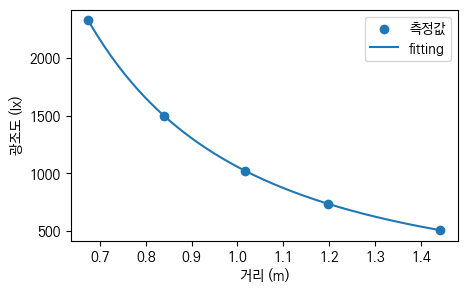

In [11]:
# 연습문제: 다음은 실제 광도표준전구를 점등하여 여러 위치에서 측정한
# 광조도 값이다. 광도와 거리옵셋을 구하라.

거리 = np.array([0.6744, 0.8407, 1.0162, 1.1968, 1.4424])  # 단위: m
광조도 = np.array([2326, 1494, 1023, 736.9, 507.2])  # 단위: lx


# 모델 함수 f_Ev = Iv/(r+delta)^2
def f_Ev(r, Iv, delta):
    return Iv / (r + delta) ** 2


# fitting
(광도, 옵셋), _ = curve_fit(
    f_Ev, 거리, 광조도, method="lm", p0=[광조도[-1] * 거리[-1] ** 2, 0]
)

# 결과 출력
print(f"광도 {광도:4.0f} cd, 거리 옵셋 {옵셋*1000:3.1f} mm")
# 그림으로 도식화
plt.figure(figsize=[5, 3])
plt.scatter(거리, 광조도, marker="o")
x = np.linspace(거리[0], 거리[-1], 500)
plt.plot(
    x,
    f_Ev(x, 광도, 옵셋),
)
plt.xlabel("거리 (m)")
plt.ylabel("광조도 (lx)")
plt.legend(["측정값", "fitting"])
plt.show()

## 광휘도 (luminance)
* `광원`의 단위면적(사영된)이 단위입체각으로 발산하는 광선속 (단위: lm/m<sup>2</sup>sr, cd/m<sup>2</sup>, nt)

$$ L_v = {d^2 \Phi_v \over d\Omega dA \cos\theta} $$

<img src="그림_광휘도의_기하학적_조건.png" width="500px" title="광휘도의 기하학적 조건" alt="광휘도의 기하학적 조건"></img>
* 휘도 보존의 법칙: 빛살은 새로 생성되거나 소멸되지 않음 (에너지 보존).
* 인간의 눈이 감지하는 빛 자극과 직접 관련됨.

## 람베르트 (Lambertian) 광원
* 광휘도가 각도에 따라서 변하지 않고 일정한 광원: $I_v(\theta) \propto \cos\theta$
* 예) 적분구 광원, 오팔유리와 균일한 조명으로 만들어진 광원

연습문제: 광휘도가 $L$ 면적이 $A$ 인 람베르트 광원이 내어놓는 전체 광선속 $\Phi$은?
> 람베르트 광원은 각도, 위치에 무관하게 상수 $L$의 광휘도 값을 갖는다.
> 
> 광휘도의 정의에 따라, $$\Phi = \int\int L \cos\theta dA d\Omega  = L \int dA \int \cos\theta d\Omega  = LA \int \cos\theta d\Omega $$
> 
> 여기서, 입체각의 적분은
> 
> $$ \int \cos\theta d\Omega = 2\pi \int_0^{\pi/2} \cos\theta \sin\theta d\theta = \pi \int_0^{\pi/2} \sin 2\theta d\theta = \pi $$
> 
> 따라서, $\Phi = \pi LA$

In [12]:
# 300 cd/m^2 광휘도를 내는 600 mm x 350 mm의 디스플레이 패널의
# 전체 광선속은 얼마인가? (람베르트 광원 근사)

광휘도 = 300
면적 = 600e-3 * 350e-3
광선속 = pi * 광휘도 * 면적
print(f"광선속: {광선속:5.1f} lm")

광선속: 197.9 lm


## 람베르트 광원 원반의 광휘도와 검출 원반의 광조도 사이의 관계
<img src="그림_두원반의_광휘도_광조도_관계.png" width="400px" title="두 원반의 광휘도 광조도 관계" alt="두 원반의 광휘도 광조도 관계"></img>
$$E_d = {L_s A_s \over d^2} \left[{d^2 \left(r_s^2 + r_d^2 + d^2 - \sqrt{(r_s^2 + r_d^2 + d^2)^2 -4r_d^2 r_s^2}\right) \over 2 r_d^2 r_s^2} \right]$$

연습문제: 아래와 같이 광조도계를 설계하였다. 
* 확산판은 람베르트 투과특성을 갖고, 
* 확산판(Edmund 34441), 
* 색필터1(Edmund 34453), 
* 색필터2(Edmund 15709)의 분광투과율과 
* Si 광다이오드(Thorlabs SM05PD1A)의 분광감응도가 아래와 같이 주어질 때, 
1. CIE A 표준광 100 lx 입사 시 Si 광다이오드의 출력전류를 계산하라.
2. CIE D65 표준광 100 lx 입사 시 Si 광다이오드의 출력전류를 계산하라.

<img src="그림_광조도계.png" width="400px" title="광조도계" alt="광조도계"></img>

     diffuser  filter1   filter2        PD
w                                         
350  0.129657      0.0  0.645380  0.000000
355  0.144950      0.0  0.701482  0.000000
360  0.154249      0.0  0.754761  0.000000
365  0.159405      0.0  0.771835  0.045889
370  0.161938      0.0  0.785108  0.046280


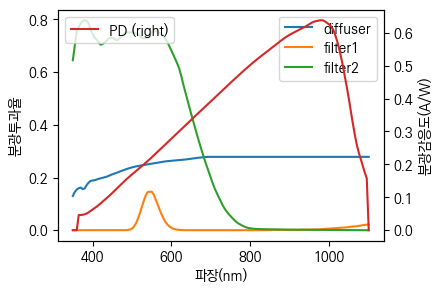

In [13]:
# 광조도계를 구성하는 요소의 광학적 특성 데이터 불러오기
# 확산판, 색필터 1, 색필터2의 분광투광율, Si 광다이오드의 분광감응도
dat = pd.read_excel("illuminance_meter.xlsx", index_col=0)

# 데이터 보여주기
print(dat.head())

# 데이터 플롯
dat.loc[:, ["diffuser", "filter1", "filter2"]].plot(figsize=[4.2, 3], xlabel="파장(nm)")
plt.ylabel("분광투과율")
dat["PD"].plot(secondary_y=True, xlabel="파장(nm)")
plt.ylabel("분광감응도(A/W)")
plt.legend()
plt.show()

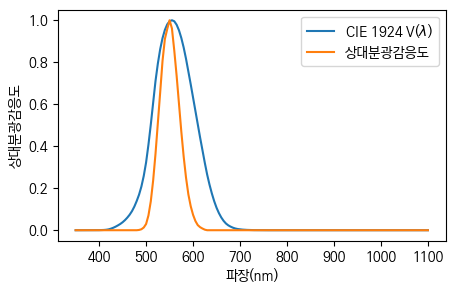

In [14]:
# 상대분광감응도 계산 및 플롯
plt.figure(figsize=[5, 3])
plt.plot(dat.index, f_V(dat.index), label=r"CIE 1924 V($\lambda$)")
s_rel = dat["diffuser"] * dat["filter1"] * dat["filter2"] * dat["PD"]
s_rel /= s_rel.max()
plt.plot(dat.index, s_rel, label=r"상대분광감응도")
plt.xlabel("파장(nm)")
plt.ylabel("상대분광감응도")
plt.legend()
plt.show()

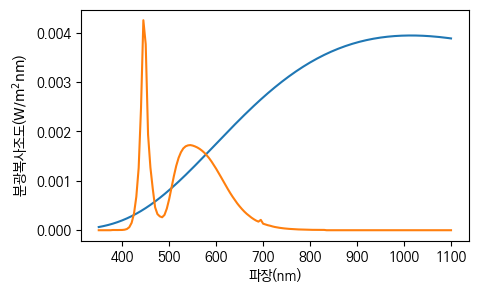

(100.00000000000001, 100.00000000000001)

In [15]:
# CIE A 표준광의 분광분포 함수 정의
f_A = (
    lambda w: 100
    * (560 / w) ** 5
    * (np.exp(1.435e7 / (2848 * 560)) - 1)
    / (np.exp(1.435e7 / (2848 * w)) - 1)
)
# CIE A 표준광
Sa = f_A(dat.index)
# 색온도 6500 K의 백색 LED
Sb = d2.LED_W65.reindex(dat.index, fill_value=0)

# CIE A 표준광 100 lx의 분광복사조도
Ea = 100 / np.sum(K_m * Sa * f_V(dat.index) * 5) * Sa  # W/m^2nm
Eb = 100 / np.sum(K_m * Sb * f_V(dat.index) * 5) * Sb  # W/m^2nm
plt.figure(figsize=[5, 3])
plt.plot(dat.index, Ea)
plt.plot(dat.index, Eb)
plt.xlabel("파장(nm)")
plt.ylabel(r"분광복사조도($\mathrm{W/m^2nm}$)")
plt.show()
# 광조도값 확인
Ea_v = np.sum(K_m * Ea * f_V(dat.index) * 5)
Eb_v = np.sum(K_m * Eb * f_V(dat.index) * 5)
Ea_v, Eb_v

In [16]:
# 분광복사조도 E가 확산판을 통과한 뒤의 분광복사휘도
La_s = Ea * dat.diffuser / pi  # W/m^2nm sr
Lb_s = Eb * dat.diffuser / pi  # W/m^2nm sr

# 필터 1과 필터2를 통과한 뒤의 분광복사휘도
La_s *= dat.filter1 * dat.filter2  # W/m^2nm sr
Lb_s *= dat.filter1 * dat.filter2  # W/m^2nm sr

# L_s가 Si 광다이오드 표면에 전달한 분광복사조도 계산
r_s, r_d, d = 10e-3 / 2, 4e-3 / 2, 5e-3
A_s, A_d = pi * r_s**2, pi * r_d**2
Ea_d = (
    La_s
    * A_s
    / (2 * r_d**2 * r_s**2)
    * (
        r_s**2
        + r_d**2
        + d**2
        - np.sqrt((r_s**2 + r_d**2 + d**2) ** 2 - 4 * r_d**2 * r_s**2)
    )
)
Eb_d = (
    Lb_s
    * A_s
    / (2 * r_d**2 * r_s**2)
    * (
        r_s**2
        + r_d**2
        + d**2
        - np.sqrt((r_s**2 + r_d**2 + d**2) ** 2 - 4 * r_d**2 * r_s**2)
    )
)

# Si 광다이오드 전체에 입사한 분광복사선속
Phia_d = Ea_d * A_d  # W/nm
Phib_d = Eb_d * A_d  # W/nm

# Si 광다이오드의 출력전류
Ia_d = (Phia_d * dat.PD * 5).sum()
Ib_d = (Phib_d * dat.PD * 5).sum()

# 결과출력
print(
    f"CIE A 표준광: 입사 광조도 {Ea_v:5.1f} lx 일 때, 광조도계의 출력전류 {Ia_d:5.3e} A"
)
print(
    f"W LED 6500K: 입사 광조도 {Eb_v:5.1f} lx 일 때, 광조도계의 출력전류 {Ib_d:5.3e} A"
)

CIE A 표준광: 입사 광조도 100.0 lx 일 때, 광조도계의 출력전류 2.441e-09 A
W LED 6500K: 입사 광조도 100.0 lx 일 때, 광조도계의 출력전류 3.095e-09 A


## 광휘도 일차 표준
* 한국표준과학연구원을 비롯한 대부분의 국가의 표준기관은 광검출기 기반 광휘도 눈금 확립 방법을 따름.
* 광조도 ($E_d$) + 정밀개구의 면적 ($A_s$) + 거리 ($d$) → 광휘도 ($L_s$)

<img src="그림_광휘도_표준광원_교정.png" width="600px" title="광휘도 값 결정" alt="광휘도 값 결정"></img>

$$L_s = \left\{1 + \left( r_s \over d\right)^2 + \left( r_d \over d\right)^2 \right\} {E_d d^2 \over A_s}~~\textrm{단,}~~r_s,~r_d \ll d$$

In [17]:
# 연습문제: 적분구 광원의 출사창 직경 25 mm, 광조도계의 검출면 직경 15 mm,
# 적분구-광조도계 간 거리 500 mm 이고, 광조도계로 측정한 광조도 값이 10 lx 일 때,
# 적분구 광원의 광휘도를 구하라.

r_a = (25e-3) / 2
A = pi * r_a**2
r_d = (15e-3) / 2
d = 500e-3
E_v = 10
L_v = (1 + (r_a / d) ** 2 + (r_d / d) ** 2) * E_v * d**2 / A
print(f"광휘도 : {L_v:4.0f} nt")

광휘도 : 5097 nt


## 광휘도 표준광원
* 여러 광휘도 수준을 만들어 낼 수 있도록 적분구 내에 광출력을 조절할 수 있는 수단이 마련되어 있음.
  * 백열전구의 경우 동작전류를 변경시키면 분광분포가 변하기 때문에 전류를 조절하는 대신 조리개를 통해 출력을 조절함.
* 적분구의 재질은 BaSO<sub>4</sub> (가시광선-적외선)나 PTFE (자외선-적외선). 
* 모니터 광휘도계는 온도 제어기가 필요할 수 있음.  → $V(\lambda)$ 정합 필터의 온도 의존성
* 백열전구는 출사개구로 발산되는 빛이 2856 K의 색온도를 갖도록 전류를 조정한 뒤 고정함 (전류 변경시 색온도가 변함).
* 적분구의 분광출력효율 (spectral throughput)이 파장의 함수이기 때문에, 색온도가 2856 K 적분구 광원의 분광분포는 CIE A 표준광원의 분광분포와 차이가 있음.

<img src="그림_광휘도_표준광원.png" width="600px" title="광휘도 표준광원" alt="광휘도 표준광원"></img>

## 적분구 (integrating sphere)
* 내벽이 반사율이 높은 람베르트 확산 재료로 형성되어 있는 구 형태의 광학 소자로, BaSO<sub>4</sub> 도료나 PTFE 블럭 등의 재료로 만들어 짐.
* 적분구로 입사한 광선속이 적분구 내벽에 공간적으로 균일한 광휘도를 형성함.

<img src="그림_적분구_복사전달.png" width="350px" title="적분구 복사전달" alt="적분구 복사전달"></img>

적분구의 내벽의 한 요소 ($A_1$)가 $\Phi_v$ 만큼의 광선속을 발산하여 다른 한 요소 ($A_2$)에 만들어 내는 광조도
* $A_1$이 적분구 중심방향으로 내는 광도: $I_v(0) = {\Phi_v \over \pi}$ (람베르트 표면의 유효 입체각 = $\pi$)
* $A_1$이 $A_2$ 방향으로 내는 광도: $I_v(\theta) = {\Phi_v \over \pi} \cos\theta$
* $A_1$에서 $A_2$을 바라보았을 때의 입체각: $\Omega = {A_2 \cos\theta \over (2R\cos\theta)^2} = {A_2 \over 4R^2 \cos\theta}$
* $I_v(\theta)$가 $A_2$에 전달한 광선속: $\Phi_{2\to1} = {I_v(\theta) \Omega} = {\Phi_v A_2 \over 4\pi R^2}$
* 결과적으로 $A_1$의 $\Phi_v$가 $A_2$에 만들어 낸 광조도: $E_{2\to1} = {\Phi_{2\to1} \over A_2} = {\Phi_v \over 4\pi R^2}$ 
* $E_{2\to1}$이 $A_1$과 $A_2$의 위치(각도)에 무관하기 때문에 $A_1$과 $A_2$를 적분구의 내벽의 전체 표면적이라고 생각해도 성립한다.

적분구의 내의 한 지점에 $\Phi_v$가 입사했을 때, 반사율이 $\rho$인 적분구 내벽에 형성되는 광조도와 광휘도를 계산해보자.
1. 입사광이 적분구에서 반사한 후의 광선속과 그 광선속이 만드는 광조도: $\rho\Phi_v, {\rho\Phi_v \over 4\pi R^2}$
1. 이전 빛이 적분구에서 반사한 후의 광선속과 그 광선속이 만드는 광조도: $\rho^2\Phi_v , {\rho^2\Phi_v \over 4\pi R^2}$
1. 이전 빛이 적분구에서 반사한 후의 광선속과 그 광선속이 만드는 광조도: $\rho^3\Phi_v , {\rho^4\Phi_v \over 4\pi R^2}$
1. ...

1 ~ $\infty$ 회차까지의 중첩된 광조도를 모두 합하면,
$$ E_v = {\Phi_v \over 4\pi R^2} (\rho + \rho^2 + \rho^3 + \cdots) = {\Phi_v \over 4\pi R^2} {\rho \over 1-\rho}$$


일반적으로 적분구의 표면 반사율이 균일하지 않으므로 (뚫려있는 구멍의 경우 $\rho=0$) 이를 일반화하면, 
$$ E_v = {\Phi_v \over 4\pi R^2} {\rho_0 \over 1-\rho_e} ~~\textrm{단,}~\rho_e = {\sum_{i=1}^n {\rho_i A_i} \over \sum_{i=1}^n {A_i}}$$
여기서, $\rho_0$는 첫번째 반사가 일어나는 위치의 반사율, $\rho_e$는 유효반사율임.

반사율이 $\rho_w$인 적분구 표면의 광휘도는
$$ L_v = {\rho_w E \over \pi}= {\rho_w \Phi_v \over 4\pi^2 R^2} {\rho_0 \over 1-\rho_e} $$

In [18]:
# 연습문제: 광선속 500 lm을 직경 50 cm, 반사율 95% 적분구(시창 직경 15 cm)에
# 넣었을 때 적분구의 표면 광휘도는?

phi = 500  # 광선속 (50 W 할로겐 전구)
rho = 0.95  # 적분구 표면 반사율
R = 50e-2 / 2  # 적분구 반경
A = 4 * pi * R**2  # 적분구 표면적
r = 15e-2 / 2  # 시창 반경
a = pi * r**2  # 시창 면적
rho_e = rho * (A - a) / A  # 유효반사율
L = rho * phi / (4 * pi**2 * R**2) * rho / (1 - rho_e)
print(f"유효반사율 {rho_e:5.3} 광휘도 {L:5.0f} nt")

유효반사율 0.929 광휘도  2562 nt


## 전광선속 (total luminous flux)

* `광원`에서 전체 입체각으로 발산하는 총 광선속

$$ \Phi_v = \int_{4\pi} I_v(\theta, \phi) d\Omega $$


<img src="그림_전광선속의_기하학적_조건.png" width="400px" title="전광선속의 기하학적 조건" alt="전광선속의 기하학적 조건"></img>

## 전광선속 일차 표준
* 측각광도계를 통해 표준전구의 광도를 $4\pi$ 입체각 전체에 대해 모두 측정 후 적산함으로써 전광선속을 측정함.
* 한국표준과학연구원의 경우 회전 반경 2 m의 측각광도계를 이용하여 전광선속 표준전구를 교정하고 (일차 표준), 다시 그 표준전구를 적분구 광도계를 이용하여 복제함으로써 전광선속 눈금을 보급함.
* 측각광도계는 기계부의 회전을 동반하기 때문에 기본적으로 측정 속도가 매우 느림.

## 적분구 광도계
* 측각광도계에 비해, 싸고, 빠르지만 전광선속이 교정되어 있는 표준전구를 필요로 함.
* 최근에는 적분구 광도계보다는 적분구 분광복사계가 더 흔함. 
  * 광도계는 분광분포 불일치 오차가 취약하나 분광복사계는 분광분포 불일치가 오차가 거의 없음.
* 적분구의 구면의 형성되는 광조도가 적분구 내 광선속에 비례하는 원리를 이용
$$ E_v = {\Phi_v \over 4\pi R^2} {\rho_0 \over 1-\rho_e} $$

<style>
td, th {
   border: none!important;
}
</style>
</style>
<table>
<tr>
<td>
<img src="그림_적분구_광도계.png" width="450px" title="적분구 광도계" alt="적분구 광도계"></img>
</td>
<td>
<table>
<tr><td> Φ<sub>dut</sub></td> <td> 교정대상 전구의 전광선속 값</td>
<tr><td> Φ<sub>ref</sub></td> <td> 표준전구의 전광선속 기준값</td>
<tr><td> y<sub>ref</sub></td> <td> 기준 전구 점등 시 광조도값</td>
<tr><td> y<sub>dut</sub></td> <td> 교정대상 전구 점등 시 광조도값</td>
<tr><td> x<sub>ref</sub></td> <td> 보조 전구 점등 상태에서 기준 전구 장착 시 광조도값</td>
<tr><td> x<sub>dut</sub></td> <td> 보조 전구 점등 상태에서 교정대상 전구 장착 시 광조도값</td>
</table>
</td>
</table>

$$ \Phi_{dut} = \Phi_{ref} {y_{dut} \over y_{ref}} {x_{ref} \over x_{dut}}  $$

* 차광판과 적분구 내벽의 반사율은 가능한 높은 것이 좋음 (단, 자체흡수 불일치 보정을 할 경우)
* 일반적으로 전구는 점등자세 (base-up 혹은 base-down)에 따라 전광선속 값이 달라짐 (백열전구, LED 등)
* 기준 전광선속 표준전구와 교정대상 전구와의 “차이”는 모두 오차요인임: 색깔, 배광, 크기/모양/재질 등

In [19]:
# 연습문제: 적분구 광도계를 이용하여 전구 x의 전광선속을 측정하려고 한다.
# 기준으로 사용한 표준전구의 전광선속은 1000 lm이고, 표준전구 점등 시 기기의
# 지시값은 50 lx, 전구 x 점등 시 기기의 지시값은 40 lx 이었다. 또한, 보조전구
# 점등 하에서 표준전구 장착 시 기기의 지시값은 100 lx, 전구 x 장착 시 기기의
# 지시값은 102 lx 이었다. 전구 x의 전광선속은?

Phi_ref = 1000
y_ref, y_dut = 50, 40
x_ref, x_dut = 100, 102
Phi_dut = Phi_ref * y_dut / y_ref * x_ref / x_dut
print(f"전광선속 : {Phi_dut:5.1f} lm")

전광선속 : 784.3 lm


## 적분구 광도계의 정상 동작을 담보하기 위한 조건
1. 광원은 반사율이 높은 표면만 바라봐야 한다.
1. 광원과 마주 보는 면은 광원에서 멀리 떨어져 있어야 한다. 

# 광원색(光原色, source color)
* 광원색은 광원에서 방출되는 빛의 분광분포 중 R, G, B 성분이 어떻게 분포하는지에 관한 것
* 정량적으로는 등색함수 $\bar{x}(\lambda)$, $\bar{y}(\lambda)$, $\bar{z}(\lambda)$와 광원의 분광분포 $S(\lambda)$로부터 산출되는 삼자극치 $X$, $Y$, $Z$ 로 결정됨.
* 광원색 측정량에는 다음과 같이 다양한 측정량이 존재함.
  1. CIE 1931 $(x,~y)$ 색좌표
  2. CIE 1976 $(u',~v')$ 색좌표 _cf_. CIE 1960 $(u,~v)$
  3. 상관색온도 (correlated color temperature)
  4. 으뜸파장 (dominant wavelength)
  5. `연색지수 (color rendering index)`
  * 1 ~ 4는 모두 삼자극치 $X$, $Y$, $Z$ 로 결정할 수 있음. 

## 삼자극치 (tristimulus value)
* 분광분포 내에 각각 적색($X$), 녹색($Y$), 청색($Z$) 자극량을 얼마나 포함하고 있는 지를 정량화한 것
* $Y$는 광측정량(photometric integral)으로 $S(\lambda)$가 분광복사휘도일 경우 광휘도, 분광복사조도일 경우 광도, 분광복사선속일 경우 광선속에 해당함. 
  * $\bar{y}(\lambda) = V(\lambda)$

$$ X = K_m \int_{380~\textrm{nm}}^{780~\textrm{nm}} {S(\lambda)\bar{x}(\lambda)d\lambda} $$
$$ Y = K_m \int_{380~\textrm{nm}}^{780~\textrm{nm}} {S(\lambda)\bar{y}(\lambda)d\lambda} $$
$$ Z = K_m \int_{380~\textrm{nm}}^{780~\textrm{nm}} {S(\lambda)\bar{z}(\lambda)d\lambda} $$

## 물체색의 삼자극치
분광분포가 $S(\lambda)$인 조명광의 광조도가 100 lx로 정규화되어 있다고 가정하고,
$$ \left(\textrm{즉,}~K_m \int_{380~\textrm{nm}}^{780~\textrm{nm}} {S(\lambda)\bar{y}(\lambda)d\lambda} = 100~\textrm{lx} \right)$$

* 반사색의 경우, 물체의 반사율을 $\rho(\lambda)$라고 하면
$$ X = K_m \int_{380~\textrm{nm}}^{780~\textrm{nm}} {\rho(\lambda)S(\lambda)\bar{x}(\lambda)d\lambda} $$
$$ Y = K_m \int_{380~\textrm{nm}}^{780~\textrm{nm}} {\rho(\lambda)S(\lambda)\bar{y}(\lambda)d\lambda} $$
$$ Z = K_m \int_{380~\textrm{nm}}^{780~\textrm{nm}} {\rho(\lambda)S(\lambda)\bar{z}(\lambda)d\lambda} $$
* 투과색의 경우, 물체의 투과율을 $\tau(\lambda)$라고 하면
$$ X = K_m \int_{380~\textrm{nm}}^{780~\textrm{nm}} {\tau(\lambda)S(\lambda)\bar{x}(\lambda)d\lambda} $$
$$ Y = K_m \int_{380~\textrm{nm}}^{780~\textrm{nm}} {\tau(\lambda)S(\lambda)\bar{y}(\lambda)d\lambda} $$
$$ Z = K_m \int_{380~\textrm{nm}}^{780~\textrm{nm}} {\tau(\lambda)S(\lambda)\bar{z}(\lambda)d\lambda} $$

           x2        y2        z2
w                                
360  0.000130  0.000004  0.000606
365  0.000232  0.000007  0.001086
370  0.000415  0.000012  0.001946
375  0.000742  0.000022  0.003486
380  0.001368  0.000039  0.006450


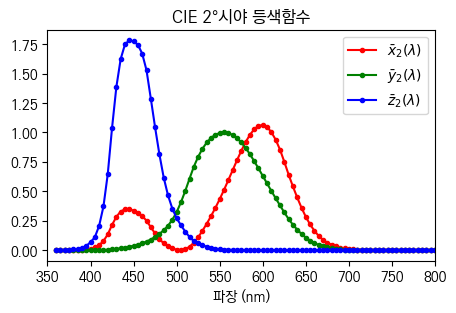

In [20]:
# 2도 시야 등색함수
d3 = pd.read_excel(
    "CIE_data.xlsx", sheet_name="CIE_CMF", index_col=0, usecols=[0, 1, 2, 3]
)
print(d3.head())
d3.plot(
    figsize=(5, 3),
    xlim=(350, 800),
    marker=".",
    xlabel="파장 (nm)",
    color=["r", "g", "b"],
    title="CIE 2°시야 등색함수",
)
plt.legend([r"$\bar{x}_2(\lambda)$", r"$\bar{y}_2(\lambda)$", r"$\bar{z}_2(\lambda)$"])
plt.show()

X = 8.095e+06, Y = 7.369e+06, Z = 2.622e+06


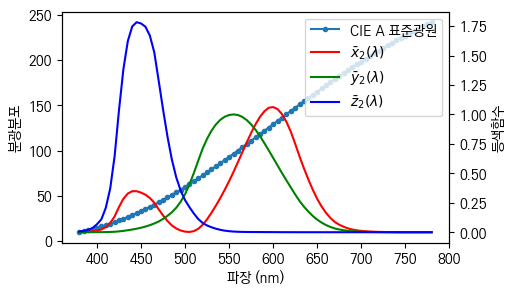

In [21]:
# 연습문제: CIE A 표준광원의 X, Y, Z 삼자극치를 구하라
# 참고: CIE A 표준광원의 분광분포
#   f_A(w) =
#   100(560/w)^5[exp(1.435E7/(2848*560))-1]/[exp(1.435E7/(2848*w))-1]


# 삼자극치 계산함수의 정의
def tristimulus(S):
    X = dw * K_m * d3.x2[w].mul(S).sum()
    Y = dw * K_m * d3.y2[w].mul(S).sum()
    Z = dw * K_m * d3.z2[w].mul(S).sum()
    return X, Y, Z


# CIE A 표준광원의 분광분포 함수 정의
f_A = (
    lambda w: 100
    * (560 / w) ** 5
    * (np.exp(1.435e7 / (2848 * 560)) - 1)
    / (np.exp(1.435e7 / (2848 * w)) - 1)
)
# 분광분포 계산
S = f_A(w)
# 삼자극치 계산
X, Y, Z = tristimulus(S)
# 삼자극치 출력
print(f"X = {X:5.3e}, Y = {Y:5.3e}, Z = {Z:5.3e}")
# 그래프로 표현
fig, ax1 = plt.subplots(figsize=(5, 3))
ax2 = ax1.twinx()
ax1.plot(w, S, ".-")
ax2.plot(w, d3.x2[w], "r-")
ax2.plot(w, d3.y2[w], "g-")
ax2.plot(w, d3.z2[w], "b-")
ax1.set_xlabel("파장 (nm)")
ax1.set_ylabel("분광분포")
ax2.set_ylabel("등색함수")
lines = ax1.get_lines() + ax2.get_lines()
ax2.legend(
    lines,
    [
        r"CIE A 표준광원",
        r"$\bar{x}_2(\lambda)$",
        r"$\bar{y}_2(\lambda)$",
        r"$\bar{z}_2(\lambda)$",
    ],
)
plt.show()

## CIE 1931 (x, y) 색좌표
$$ x = {X \over X + Y + Z},~y = {Y \over X+Y+Z} $$

CIE 1931 (x, y) = (0.4476, 0.4074)


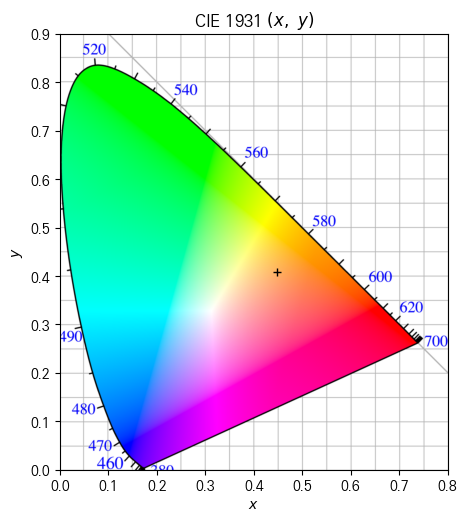

In [22]:
# 연습문제: CIE A 표준광원의 CIE 1931 (x, y) 색좌표를 구하라.


# XYZ -> xy 계산 함수 정의
def CIE1931xy(X, Y, Z):
    return X / (X + Y + Z), Y / (X + Y + Z)


# CIE 1931 색좌표계 도시 함수 정의
def show_CIE1931(x, y):
    img = plt.imread("CIE1931_cropped.png")
    plt.figure(figsize=(5, 6))
    plt.imshow(img, extent=[0, 0.8, 0, 0.9])
    plt.plot(x, y, "k+")
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.title("CIE 1931 $(x,~y)$")
    plt.show()


# CIE 1931 (x, y) 색좌표 계산
x, y = CIE1931xy(X, Y, Z)
# CIE 1931 (x, y) 색좌표 출력
print(f"CIE 1931 (x, y) = ({x:6.4f}, {y:6.4f})")
# CIE 1931 (x, y) 색좌표계 도시
show_CIE1931(x, y)

## CIE 1976 (u', v') 색좌표
$$ u' = {4x \over -2x + 12y +3},~v' = {9y \over -2x + 12y +3} $$
$$ u = {4X \over X + 15Y +3Z},~v = {9Y \over X + 15Y +3Z} $$

CIE 1976 (u', v') = (0.2560, 0.5243)


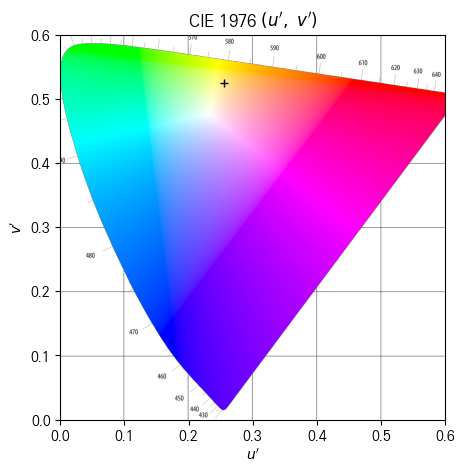

In [23]:
# 연습문제: CIE A 표준광원의 CIE 1976 (u', v') 색좌표를 구하라.


# xy -> u'v' 계산 함수 정의
def CIE1976uv_from_xy(x, y):
    return 4 * x / (-2 * x + 12 * y + 3), 9 * y / (-2 * x + 12 * y + 3)


# CIE 1976 색좌표계 도시 함수 정의
def show_CIE1976(up, vp):
    img = plt.imread("CIE1976_cropped.png")
    plt.figure(figsize=(5, 5))
    plt.imshow(img, extent=[0, 0.6, 0, 0.6])
    plt.plot(up, vp, "k+")
    plt.xlabel("$u'$")
    plt.ylabel("$v'$")
    plt.title("CIE 1976 $(u',~v')$")
    plt.show()


up, vp = CIE1976uv_from_xy(x, y)
print(f"CIE 1976 (u', v') = ({up:6.4f}, {vp:6.4f})")
show_CIE1976(up, vp)

## CIE 1960 (u, v) 색좌표 
* 현재는 폐기되었으며, 상관색온도 계산에만 사용됨.
$$ u = {4x \over -2x + 12y +3},~v = {6y \over -2x + 12y +3} $$
$$ u = {4X \over X + 15Y +3Z},~v = {6Y \over X + 15Y +3Z} $$

CIE 1960 (u, v) = (0.2560, 0.3495)


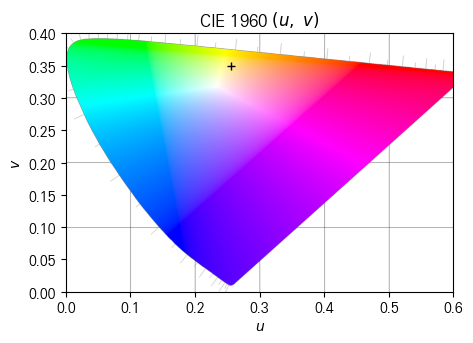

In [24]:
# 연습문제: CIE A 표준광원의 CIE 1960 (u, v) 색좌표를 구하라.


# xy -> uv 계산 함수
def CIE1960uv_from_xy(x, y):
    return 4 * x / (-2 * x + 12 * y + 3), 6 * y / (-2 * x + 12 * y + 3)


# CIE 1976 색좌표계 도시 함수 정의
def show_CIE1960(u, v):
    img = plt.imread("CIE1960_cropped.png")
    plt.figure(figsize=(5, 4))
    plt.imshow(img, extent=[0, 0.6, 0, 0.4])
    plt.plot(u, v, "k+")
    plt.xlabel("$u$")
    plt.ylabel("$v$")
    plt.title("CIE 1960 $(u,~v)$")
    plt.show()


# CIE 1960 (u, v) 색좌표 계산
u, v = CIE1960uv_from_xy(x, y)
# CIE 1960 (u, v) 색좌표 출력
print(f"CIE 1960 (u, v) = ({u:6.4f}, {v:6.4f})")
# CIE 1960 (u, v) 색좌표계 도시
show_CIE1960(u, v)

In [25]:
# 디스플레이 색역 (color gamut)
# sRGB B, G, R, W 점의 (x, y)
sRGB_x = [0.150, 0.300, 0.640, 0.313]
sRGB_y = [0.060, 0.600, 0.330, 0.329]
# Adobe RGB B, G, R, W 점의 (x, y)
Adobe_x = [0.150, 0.210, 0.640, 0.313]
Adobe_y = [0.060, 0.710, 0.330, 0.329]
# P3-D65 B, G, R, W 점의 (x, y)
P3_D65_x = [0.150, 0.265, 0.680, 0.313]
P3_D65_y = [0.060, 0.690, 0.320, 0.329]

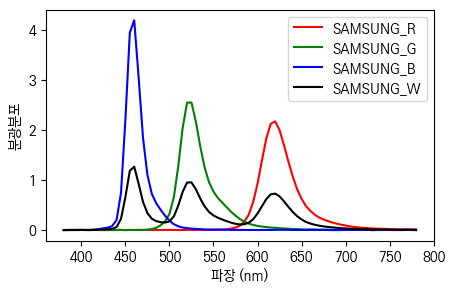

SAMSUNG_R (0.6694, 0.3305)
SAMSUNG_G (0.2219, 0.7147)
SAMSUNG_B (0.1404, 0.0481)
SAMSUNG_W (0.3063, 0.3307)


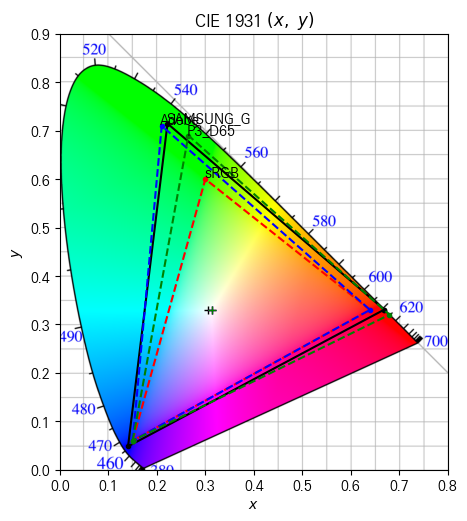

In [26]:
# 연습문제: 삼성 갤럭시 휴대폰의 R, G, B 원색과 W의 CIE 1931 색좌표를 계산하라.


# 여러 스펙트럼에 대한 CIE 1931 xy 색좌표 계산 함수 정의
def CIE1931xy_list(S):
    X = K_m * S.mul(d3.x2[w], axis=0).sum() * dw
    Y = K_m * S.mul(d3.y2[w], axis=0).sum() * dw
    Z = K_m * S.mul(d3.z2[w], axis=0).sum() * dw
    return X / (X + Y + Z), Y / (X + Y + Z)


#  색역 도시 함수 정의
def show_gamut(x, y, title=""):
    img = plt.imread("CIE1931_cropped.png")
    plt.figure(figsize=(5, 6))
    plt.imshow(img, extent=[0, 0.8, 0, 0.9])
    plt.plot([*x[:-1], x[0]], [*y[:-1], y[0]], "k.-")
    plt.plot(x[-1], y[-1], "k+")
    plt.text(x[1] - 0.003, y[1] + 0.005, title)
    plt.plot([*sRGB_x[:-1], sRGB_x[0]], [*sRGB_y[:-1], sRGB_y[0]], "r.--")
    plt.plot(sRGB_x[-1], sRGB_y[-1], "r+")
    plt.text(sRGB_x[1] - 0.003, sRGB_y[1] + 0.005, "sRGB")
    plt.plot([*Adobe_x[:-1], Adobe_x[0]], [*Adobe_y[:-1], Adobe_y[0]], "b.--")
    plt.plot(Adobe_x[-1], Adobe_y[-1], "b+")
    plt.text(Adobe_x[1] - 0.003, Adobe_y[1] + 0.005, "Adobe")
    plt.plot([*P3_D65_x[:-1], P3_D65_x[0]], [*P3_D65_y[:-1], P3_D65_y[0]], "g.--")
    plt.plot(P3_D65_x[-1], P3_D65_y[-1], "g+")
    plt.text(P3_D65_x[1] - 0.003, P3_D65_y[1] + 0.005, "P3_D65")
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.title("CIE 1931 $(x,~y)$")
    plt.show()


# 삼성 갤럭시 휴대폰의 R, G, B 원색과 W 스펙트럼
cols = ["SAMSUNG_R", "SAMSUNG_G", "SAMSUNG_B", "SAMSUNG_W"]
S = d2.loc[w, cols]
S.plot(
    color=["r", "g", "b", "k"], xlabel="파장 (nm)", ylabel="분광분포", figsize=[5, 3]
)
plt.show()

# CIE 1931 xy 색좌표 계산
x, y = CIE1931xy_list(S)
for col, xi, yi in zip(cols, x, y):
    print(f"{col} ({xi:6.4f}, {yi:6.4f})")

# 색역 도시
show_gamut(x.values, y.values, cols[1])

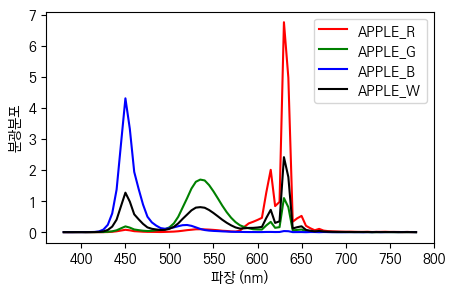

APPLE_R (0.6502, 0.3243)
APPLE_G (0.3098, 0.6062)
APPLE_B (0.1521, 0.0559)
APPLE_W (0.3281, 0.3368)


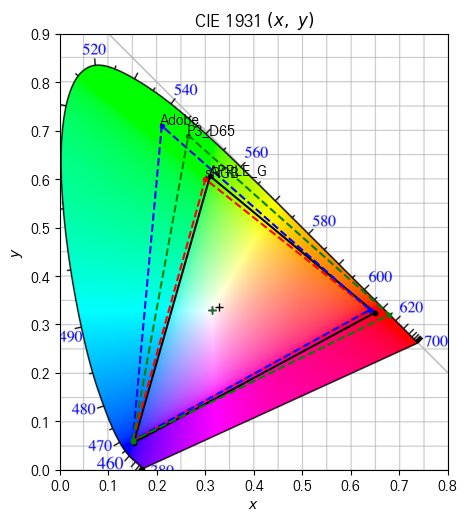

In [27]:
# 연습문제: 애플 아이폰 휴대폰의 R, G, B 원색과 W의 CIE 1931 색좌표를 계산하라.

# 애플 아이폰 휴대폰의 R, G, B 원색과 W 스펙트럼

cols = ["APPLE_R", "APPLE_G", "APPLE_B", "APPLE_W"]
S = d2.loc[w, cols]
S.plot(
    color=["r", "g", "b", "k"], xlabel="파장 (nm)", ylabel="분광분포", figsize=[5, 3]
)
plt.show()

# CIE 1931 xy 색좌표 계산
x, y = CIE1931xy_list(S)
for col, xi, yi in zip(cols, x, y):
    print(f"{col} ({xi:6.4f}, {yi:6.4f})")

# 색역 도시
show_gamut(x.values, y.values, cols[1])

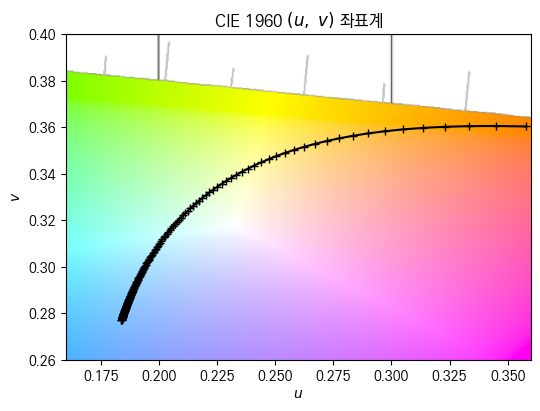

In [28]:
# 연습문제: 온도 T 흑체의 CIE 1960 (u, v) 색좌표계 상 궤적을 그려라

# 복사상수
c1, c2 = 3.74177e-16, 1.43878e-2


# 흑체의 분광분포
def f_bb(w, T):
    return c1 / (w * 1e-9) ** 5 / ((np.exp(c2 / (w * 1e-9 * T))) - 1) * 1e-9


# 1500 K ~ 20000 K 까지 100 K 간격의 흑체의 (u, v) 궤적 계산
u_bb_list = []
v_bb_list = []
for T in range(1500, 20000 + 100, 100):
    S = f_bb(w, T)
    X, Y, Z = tristimulus(S)
    u_bb, v_bb = CIE1960uv_from_xy(*CIE1931xy(X, Y, Z))
    u_bb_list.append(u_bb)
    v_bb_list.append(v_bb)


# CIE1960 좌표계 도시 함수 정의
def show_CIE1960_CCT(u, v):
    img = plt.imread("CIE1960_cropped.png")
    plt.figure(figsize=(6, 5))
    plt.imshow(img, extent=[0, 0.6, 0, 0.4])
    plt.plot(u, v, "k+")
    plt.plot(u_bb_list, v_bb_list, "k-")
    plt.xlim([0.16, 0.36])
    plt.ylim([0.26, 0.40])
    plt.xlabel("$u$")
    plt.ylabel("$v$")
    plt.title("CIE 1960 $(u,~v)$ 좌표계")
    plt.show()


# CIE 1960 색좌표계에 u_bb,v_bb 도시
show_CIE1960_CCT(u_bb_list, v_bb_list)

## 상관색온도 (correlated color temperature) 와 $D_{uv}$
* 상관색온도
  * 대상 광원의 색과 온도 $T$의 흑체의 색을 CIE 1960 $(u,~v)$ 좌표계에서 비교하였을 때 가장 비슷해 보이는 흑체의 온도
* $D_{uv}$
  * 대상 광원의 색좌표 $(u,~v)$와 대상 광원의 상관색온도 $T$에 해당하는 흑체의 색좌표 $(u_{bb}(T), v_{bb}(T))$간 거리 
    * 광원의 색깔이 얼마나 흑체 궤적에서 멀리 떨어져 있는지를 정량화한 양
    * 대상 광원의 $(u,~v)$가 흑체 궤적 위에 있을 경우 $D_{uv}$의 부호는 +
    * 대상 광원의 $(u, v)$가 흑체 궤적 위에 있을 경우 $D_{uv}$의 부호는 -
* 광원의 조명 성능에 관한 측정량으로 기본적으로 백색광에 대해서 적용됨.

iter:    0, correction: 1.17e+01,  T= 1011.7, Duv = -0.1920
iter:   50, correction: 1.04e+01,  T= 1763.1, Duv = -0.0727
iter:  100, correction: 7.02e+00,  T= 2184.5, Duv = -0.0366
iter:  150, correction: 5.46e+00,  T= 2491.7, Duv = -0.0176
iter:  200, correction: 4.54e+00,  T= 2739.4, Duv = -0.0052
iter:  241, correction: -8.81e-05, T= 2855.0, Duv = -0.0000
경사하강법에 의한 CCT = 2855.0 K, Duv = 0.0000


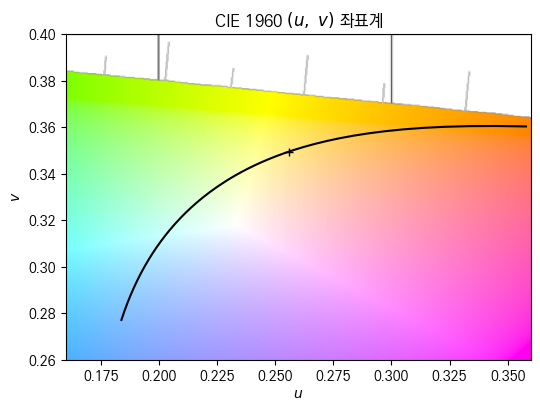

In [29]:
# 연습문제: CIE A 표준광원의 상관색온도와 Duv를 계산하라


# 경사하강법을 이용한 상관색온도 계산 함수 정의
def CCT_iteration(u, v, verbose=False):
    gain = 1e5
    dT = 0.1
    T = 1000
    correction = 0
    for iter in range(10000):
        # 온도 T 흑체와 거리 계산
        S = f_bb(w, T)
        u_bb, v_bb = CIE1960uv_from_xy(*CIE1931xy(*tristimulus(S)))
        duv_0 = np.sqrt((u_bb - u) ** 2 + (v_bb - v) ** 2)
        # 온도 T + dT 흑체와 거리 계산
        S = f_bb(w, T + dT)
        u_bb, v_bb = CIE1960uv_from_xy(*CIE1931xy(*tristimulus(S)))
        duv_1 = np.sqrt((u_bb - u) ** 2 + (v_bb - v) ** 2)
        # 거리의 미분에 gain을 곱한만큼 경사하강
        correction = (correction - (duv_1 - duv_0) / dT * gain) / 2
        T += correction
        if iter % 50 == 0 and verbose == True:
            print(
                f"iter: {iter:4d}, correction: {correction:4.2e}, \
 T= {T:6.1f}, Duv = {duv_0*np.sign(v - v_bb):6.4f}"
            )
        if abs(correction) < 1e-4:
            break
    if verbose:
        print(
            f"iter: {iter:4d}, correction: {correction:4.2e}, \
T= {T:6.1f}, Duv = {duv_0*np.sign(v - v_bb):6.4f}"
        )
    return T, duv_0


# 앞에서 구한 CIE A 표준광원의 u, v 색좌표
u, v = 0.2560, 0.3495
# 경사하강법에 의한 상관색온도 계산
CCT, Duv = CCT_iteration(u, v, verbose=True)
print(f"경사하강법에 의한 CCT = {CCT:6.1f} K, Duv = {Duv:6.4f}")
# CIE 1960 색좌표계에 u,v 도시
show_CIE1960_CCT(u, v)

## 상관색 온도를 계산하기 위한 Robertson의 방법

* 온도 $T_i$ 흑체의 $(u_i,~v_i)$ 값과 각 $(u_i,~v_i)$에서의 법선의 기울기 $m_i$를 여러 $T_i$ 값에 대해 미리 계산하여 테이블을 만들어 둠.
1. 측정 대상 광원의 $(u,~v)$와 사전에 계산해둔 데이터 테이블의 각 $(u_i,~v_i)$를 지나는 법선과의 거리 $d_i$를 계산함.
2. 계산한 거리를 기준으로 대상 광원의 $(u,~v)$와 가장 가까운 두 점 $(u_k,~v_k)$, $(u_{k+1},~v_{k+1})$과 그 때의 거리 $d_k$, $d_{k+1}$를 찾음.
3. $T_{k}^{-1}$과 $T_{k+1}^{-1}$을 $d_k$, $d_{k+1}$로 내분하는 값으로 $T^{-1}$를 결정하고, 이 값의 역수를 취해 대상 광원의 상관색온도를 구함.

$$ T^{-1} = {d_{k+1} T_k^{-1} - d_k T_{k+1}^{-1} \over d_{k+1} - d_k}~\textrm{단,}~ d_i = {(v - v_i) - m_i (u - u_i) \over \sqrt{1 + m_i^2}}$$ 

<img src="그림_CCT_Robertson.png" width="400px" title="Robertson 방법" alt="Robertson 방법"></img>
</td>


In [30]:
# 연습문제: Robertson's 방법으로 (u, v) = (0.2560, 0.3495)의 상관색온도를 구하시오
(u, v) = (0.2560, 0.3495)

# 상관색온도, u, v, 법선의 기울기를 테이블 만들기
iTbb = np.arange(10, 2000 + 10, 10)
iTbb = np.array([0.1, *iTbb])
d4 = pd.DataFrame(index=iTbb, columns=["Tbb", "u", "v", "slope"])
d4.index.name = "iTbb"
dT = 0.001
for idx in d4.index:
    T = 1e6 / idx
    S = f_bb(w, T)
    u_bb_0, v_bb_0 = CIE1960uv_from_xy(*CIE1931xy(*tristimulus(S)))
    S = f_bb(w, T + dT)
    u_bb_1, v_bb_1 = CIE1960uv_from_xy(*CIE1931xy(*tristimulus(S)))
    d4.loc[idx, "Tbb"] = T
    d4.loc[idx, "u"] = u_bb_0
    d4.loc[idx, "v"] = v_bb_0
    d4.loc[idx, "slope"] = -(u_bb_1 - u_bb_0) / (v_bb_1 - v_bb_0)
print(d4)


# Robertson 방법에 의한 CCT 계산 함수 정의
def CCT_Robertson_from_uv(u, v):
    inv_t = d4.index.to_numpy("float")  # 1E6/T
    u_t = d4["u"].to_numpy("float")  # u(T)
    v_t = d4["v"].to_numpy("float")  # v(T)
    m = d4["slope"].to_numpy("float")  # m(T) 법선의 기울기
    # 거리 계산
    d = ((v - v_t) - m * (u - u_t)) / np.sqrt(1 + m**2)
    # k 찾기
    for k in range(len(d) - 1):
        if d[k] / d[k + 1] < 0:
            break
    CCT = 1e6 / (inv_t[k] + d[k] / (d[k] - d[k + 1]) * (inv_t[k + 1] - inv_t[k]))
    # duv 계산
    a = (v_t[k + 1] - v_t[k]) / (u_t[k + 1] - u_t[k])
    Duv = (v - (a * (u - u_t[k]) + v_t[k])) / np.sqrt(1.0 + a**2)
    return CCT, Duv


# Robertson 방법에 의한 CCT 계산
CCT, Duv = CCT_Robertson_from_uv(u, v)
print(f"Robertson 방법에 의한 CCT = {CCT:6.1f} K, Duv = {Duv:6.4f}")

                 Tbb         u         v      slope
iTbb                                               
0.1       10000000.0  0.180052  0.263602       0.15
10.0        100000.0  0.180638   0.26595  -0.255529
20.0         50000.0  0.181309  0.268508  -0.269494
30.0    33333.333333  0.182067  0.271237  -0.286106
40.0         25000.0  0.182919   0.27412  -0.305413
...              ...       ...       ...        ...
1960.0    510.204082  0.585395  0.341448  10.051629
1970.0    507.614213  0.586105  0.341377   10.05083
1980.0    505.050505  0.586805  0.341307  10.050059
1990.0    502.512563  0.587494  0.341239  10.049313
2000.0         500.0  0.588173  0.341171  10.048593

[201 rows x 4 columns]
Robertson 방법에 의한 CCT = 2855.0 K, Duv = -0.0000


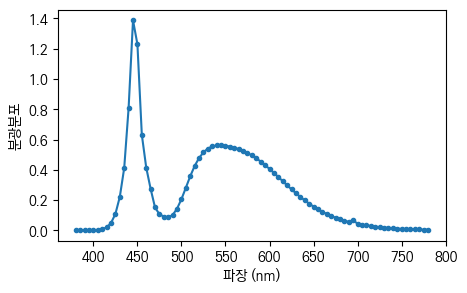

CIE 1960 (u, v) = (0.1952, 0.3130)
Robertson 방법에 의한 CCT = 6602.9 K, Duv = 0.0058


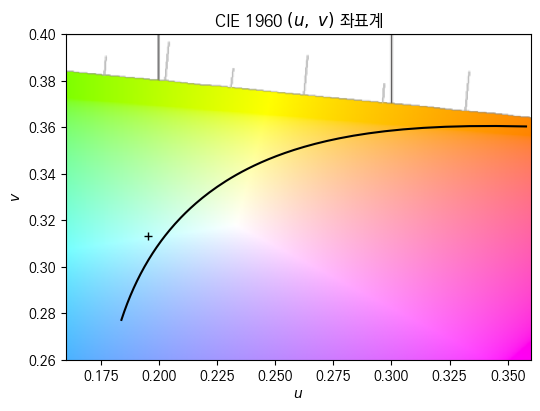

In [31]:
# 연습문제: 명목 색온도 6500 K의 백색 LED의 상관색온도와 Duv를 계산하라

# 명목 색온도 6500 K의 백색 LED의 분광분포 준비
S = d2["LED_W65"][w]
# 분광분포 플롯
S.plot(xlabel="파장 (nm)", ylabel="분광분포", marker=".", figsize=[5, 3])
plt.show()

# u, v 색좌표 계산
u, v = CIE1960uv_from_xy(*CIE1931xy(*tristimulus(S)))
print(f"CIE 1960 (u, v) = ({u:6.4f}, {v:6.4f})")

# Robertson 방법으로 CCT, Duv 계산
CCT, Duv = CCT_Robertson_from_uv(u, v)
print(f"Robertson 방법에 의한 CCT = {CCT:6.1f} K, Duv = {Duv:6.4f}")

# CIE 1960 색좌표계에 u,v 도시
show_CIE1960_CCT(u, v)

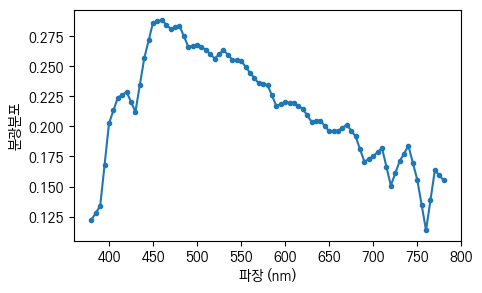

CIE 1960 (u, v) = (0.1978, 0.3122)
Robertson 방법에 의한 CCT = 6504.2 K, Duv = 0.0032


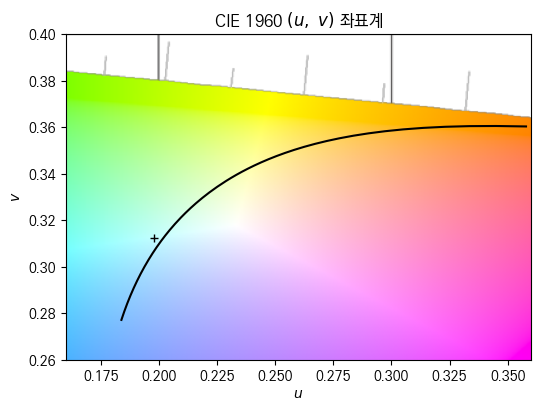

In [32]:
# 연습문제: CIE D65 표준광의 상관색온도와 Duv를 계산하라

# CIE D65 표준광의 분광분포 준비
S = d2["D65"][w]
# 분광분포 플롯
S.plot(xlabel="파장 (nm)", ylabel="분광분포", marker=".", figsize=[5, 3])
plt.show()

# u, v 색좌표 계산
u, v = CIE1960uv_from_xy(*CIE1931xy(*tristimulus(S)))
print(f"CIE 1960 (u, v) = ({u:6.4f}, {v:6.4f})")

# Robertson 방법으로 CCT, Duv 계산
CCT, Duv = CCT_Robertson_from_uv(u, v)
print(f"Robertson 방법에 의한 CCT = {CCT:6.1f} K, Duv = {Duv:6.4f}")

# CIE 1960 색좌표계에 u,v 도시
show_CIE1960_CCT(u, v)

# 연색지수 (演色指數, color rendering index)
* `조명광`의 `색 재현 능력`을 정량화한 측정량
  * 높은 연색성: 미술관의 전시 조명, 백열등, 주광(태양광)
  * 낮은 연색성: 정육점의 붉은 조명, 수은 등이나 나트륨 등으로 만들어진 가로등
* 15종의 표준 색시편이 `조명광`과 조명광과 동일한 색온도의 `기준광` 하에서 나타내는 색을 차이를 점수화한 것 (100 점 만점)
* 1번 부터 8번 색시편에 대한 점수를 평균한 것을 `일반연색지수`라고 일컫음.
* 상관색온도와 동일하게 백색광에 대해서만 의미가 있음.

,TCS01,TCS02,TCS03,TCS04,TCS05,TCS06,TCS07,TCS08,TCS09,TCS10,TCS11,TCS12,TCS13,TCS14,TCS15
w,,,,,,,,,,,,,,,
360,0.116,0.053,0.058,0.057,0.143,0.079,0.150,0.075,0.069,0.042,0.074,0.189,0.071,0.036,0.000
365,0.136,0.055,0.059,0.059,0.187,0.081,0.177,0.078,0.072,0.043,0.079,0.175,0.076,0.036,0.000
370,0.159,0.059,0.061,0.062,0.233,0.089,0.218,0.084,0.073,0.045,0.086,0.158,0.082,0.036,0.000
375,0.190,0.064,0.063,0.067,0.269,0.113,0.293,0.090,0.070,0.047,0.098,0.139,0.090,0.036,0.000
380,0.219,0.070,0.065,0.074,0.295,0.151,0.378,0.104,0.066,0.050,0.111,0.120,0.104,0.036,0.131


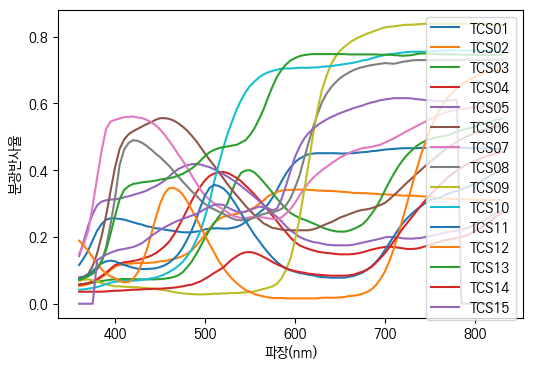

In [33]:
# 표준색 시편의 분광반사율
d5 = pd.read_excel("CIE_data.xlsx", sheet_name="CRI_TCS", index_col=0, header=2)
# 표준색 시편의 분광반사율 플롯
d5.plot(xlabel="파장(nm)", ylabel="분광반사율", figsize=[6, 4])
# 표준색 시편의 분광반사율 값 살펴보기
d5.head()

## 연색지수 계산 과정
* 연색지수의 계산은 기본적으로 평가대상 조명광(이하 대상광)의 분광분포로부터 결정된다. 
* 명목색온도 6500 K의 백색 LED를 예시로 연색지수를 계산하는 방법을 단계별로 알아보도록 한다. 

### 대상광의 분광분포 데이터를 준비한다.

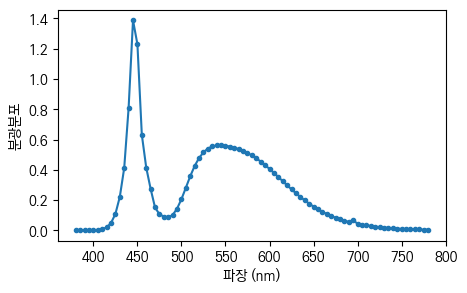

In [34]:
# 대상광 분광분포 준비
S_k = d2["LED_W65"][w]
# 대상광 분광분포 플롯
S_k.plot(xlabel="파장 (nm)", ylabel="분광분포", marker=".", figsize=[5, 3])
plt.show()

### 대상광의 광조도가 100 lx가 되도록 분광분포를 정규화한다.

In [35]:
# 삼자극치 중 광조도 값에 해당하는 Y를 계산함.
_, Y_k, _ = tristimulus(S_k)
# 100 lx 가 되도록 정규화
S_k = 100 / Y_k * S_k

### 대상광의 상관색온도를 계산한다.
* 이 과정에서, 대상광의 CIE 1960 (u, v) 색좌표 $(u_k,~v_k)$가 구해진다. 이 후, 대상광과 관련된 양은 첨자 $k$로 표시한다.

In [36]:
# 대상광의 u, v 색좌표 계산
u_k, v_k = CIE1960uv_from_xy(*CIE1931xy(*tristimulus(S_k)))
# 대상광의 u, v 색좌표 출력
print(f"({u_k:6.4f}, {v_k:6.4f})")

(0.1952, 0.3130)


In [37]:
# 대상광의 상관색온도 계산
T_k, Duv_k = CCT_Robertson_from_uv(u_k, v_k)
# 대상광의 상관색온도 출력
print(f"T_k = {T_k:6.1f}, Duv_k = {Duv_k:6.4f}")

T_k = 6602.9, Duv_k = 0.0058


### 기준광을 결정한다.
* 상관색온도가 5000 K 미만이면, 기준광은 동일한 상관색온도의 흑체이다.
* 상관색온도가 5000 K 이상이면, 기준광은 동일한 상관색온도의 주광(daylight)이다.
* 이 후, 기준광과 관련된 양은 첨자 $r$로 표시한다.

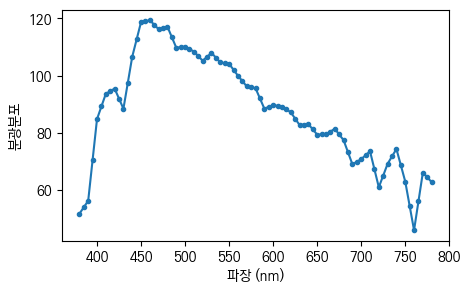

In [38]:
# CIE 주광 데이터 (S0, S1, S2) 읽어오기
d6 = pd.read_excel("CIE_data.xlsx", sheet_name="CIE_daylight", index_col=0)
# 주광의 분광분포를 만들어내는 함수 정의


def s_daylight(w, t):
    if t < 7000:
        # 온도가 4000 K ~ 7000 K 영역일 경우
        x = (
            -4.6070 * (1e9 / t**3)
            + 2.9678 * (1e6 / t**2)
            + 0.09911 * (1e3 / t)
            + 0.244063
        )
    else:
        # 온도가 7000 K ~ 25000 K 영역일 경우
        x = (
            -2.0064 * (1e9 / t**3)
            + 1.9018 * (1e6 / t**2)
            + 0.24748 * (1e3 / t)
            + 0.237040
        )
    y = -3.000 * (x**2) + 2.870 * x - 0.275
    m1 = (-1.3515 - 1.7703 * x + 5.9114 * y) / (0.0241 + 0.2562 * x - 0.7341 * y)
    m2 = (0.0300 - 31.4424 * x + 30.0717 * y) / (0.0241 + 0.2562 * x - 0.7341 * y)
    return d6.S0[w] + m1 * d6.S1[w] + m2 * d6.S2[w]


# 기준광 결정
if T_k < 5000:
    # 기준광은 흑체
    S_r = pd.Series(f_bb(w, T_k), index=w)
else:
    # 기준광은 daylight
    S_r = pd.Series(s_daylight(w, T_k), index=w)
# 기준광의 분광분포 플롯
S_r.plot(xlabel="파장 (nm)", ylabel="분광분포", marker=".", figsize=[5, 3])
plt.show()

### 기준광의 광조도가 100 lx가 되도록 분광분포를 정규화한다.

In [39]:
# 삼자극치 중 광조도 값에 해당하는 Y를 계산함.
_, Y_r, _ = tristimulus(S_r)
# 100 lx 가 되도록 정규화
S_r = 100 / Y_r * S_r

### 기준광의 CIE 1960 (u, v)를 계산한다.

In [40]:
# 기준광의 (u, v) 색좌표 계산
u_r, v_r = CIE1960uv_from_xy(*CIE1931xy(*tristimulus(S_r)))
# 기준광의 (u, v) 색좌표 출력
print(f"({u_r:6.4f}, {v_r:6.4f})")

(0.1973, 0.3115)


### 대상광과 기준광의 색차 D<sub>uv</sub>가 0.0054 보다 작은지 확인한다.
* $D_{uv} = \sqrt{(u_k-u_r)^2 + (v_k-v_r)^2}$ 를 계산하여 이 값이 $D_{uv} < 0.0054$를 확인한다.

In [41]:
# 기준광과 대상광의 u, v 색차 확인
Duv = np.sqrt((u_k - u_r) ** 2 + (v_k - v_r) ** 2)
# Duv 출력
print(f"Duv = {Duv:6.4f}")

Duv = 0.0026


### 색적응을 고려하기 위한 사전 계산을 한다.
* 기준광과 대상광의 색좌표 $(u_r,~v_r)$과 $(u_k,~v_k)$에 대해 각각 $(c_r,~d_r)$와 $(c_k,~d_k)$ 값을 계산한다
$$ c_r = {1 \over v_r(4-u_r-10v_r)},~d_r = {1 \over v_r(1.708v_r + 0.404 -1.481u_r)}$$
$$ c_k = {1 \over v_k(4-u_k-10v_k)},~d_k = {1 \over v_k(1.708v_k + 0.404 -1.481u_k)}$$

In [42]:
# 색적응을 고려하기 위해 필요한 c, d 값 계산 함수
def cd_values(u, v):
    return 1 / v * (4 - u - 10 * v), 1 / v * (1.708 * v + 0.404 - 1.481 * u)


# 기준광과 대상광에 대한 c, d 값 계산
c_r, d_r = cd_values(u_r, v_r)
c_k, d_k = cd_values(u_k, v_k)

# (u_k, v_k)의 색적응된 색좌표 (up_k, vp_k)
up_k = (10.872 + 0.404 * c_r / c_k * c_k - 4 * d_r / d_k * d_k) / (
    16.518 + 1.481 * c_r / c_k * c_k - d_r / d_k * d_k
)
vp_k = 5.520 / (16.518 + 1.481 * c_r / c_k * c_k - d_r / d_k * d_k)

# (u_k, v_k)의 색적응된 색좌표 (up_k, vp_k)가 (u_r, v_r)과 동일한 지 확인
print(
    f"(u_k, v_k) = ({u_k:6.4f}, {v_k:6.4f}), \n\
(up_k, vp_k) = ({up_k:6.4f}, {vp_k:6.4f}), \n\
(u_r, v_r) = ({u_r:6.4f}, {v_r:6.4f})"
)

(u_k, v_k) = (0.1952, 0.3130), 
(up_k, vp_k) = (0.1973, 0.3115), 
(u_r, v_r) = (0.1973, 0.3115)


### 기준광과 대상광 조명 하에서 색시편의 색좌표를 계산한다.
* 기준광과 대상광 조명 하에서 15 종의 표준 색시편에 대한 `반사색`의 색좌표 CIE 1960 $(u,~v)$과 삼자극치 중 $Y$를 계산한다.
    * 기준광 조명하에서 시편의 반사색 좌표를 $(u_{ri},~v_{ri})$, 삼자극치 $Y$를 $Y_{ri}$로 표기한다.
    * 대상광 조명하에서 시편의 반사색 좌표를 $(u_{ki},~v_{ki})$, 삼자극치 $Y$를 $Y_{ki}$로 표기한다. 

### 대상광 조명하에서 색시편의 색좌표에 색적응을 적용한다.
* 대상광 조명 하에서 색시편의 색좌표 $(u_{ki},~v_{ki})$에 대해 $(c_{ki},~d_{ki})$를 계산한다.
* 두 조명광과 색시편 반사광의 $c,~d$ 값을 이용하여 계산되며, 색적응된 색시편의 색좌표를 $(u_{pki},~v_{pki})$로 표기한다.
$$ u_{pki} = {10.872 + 0.404  {c_r \over c_k}  c_{ki} - 4 {d_r \over d_k} d_{ki} \over 16.518 + 1.481  {c_r \over c_k} c_{ki} - {d_r \over d_k}  d_{ki}}$$
$$ v_{pki} = {5.520 \over 16.518 + 1.481  {c_r \over c_k}  c_{ki} - {d_r \over d_k}  d_{ki}} $$

### 색시편의 CIE 1964 (U*, V*, W*) 색좌표를 계산한다.
색시편의 CIE 1964 $(U^*,~V^*,~W^*)$ 색좌표를 대상광 조명과 기준광 조명 하에서 각각 계산한다.
$$W^*_{ri} = 25 Y_{ri}^{1 \over 3} - 17,~~ W^*_{ki} = 25 Y_{ki}^{1 \over 3} - 17 $$
$$U^*_{ri} = 13 W^*_{ri} (u_{ri} - u_r),~~ U^*_{ki} = 13 W^*_{ki} (u_{pki} - u_{pk})$$
$$V^*_{ri} = 13 W^*_{ri} (v_{ri} - v_r),~~ V^*_{ki} = 13 W^*_{ki} (v_{pki} - v_{pk})$$

### 두 조명광 하에서 색시편의 CIE 1964 색좌표간 색차를 계산한다.
$$\Delta E_i = \sqrt{(W^*_{ki} - W^*_{ri})^2 + (U^*_{ki} - U^*_{ri})^2 + (V^*_{ki} - V^*_{ri})^2}$$

### 특수연색지수를 계산한다.
$$R_i = 100 -4.6\Delta E_i ~~\textrm{단,}~i = 1 \cdots 15$$

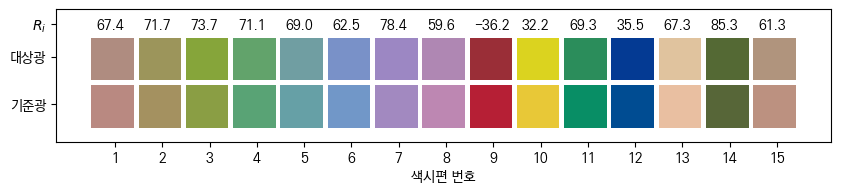

In [43]:
# 컬러 타일을 표현하기 위한 XYZ => sRGB 변환함수 정의
def XYZ2sRGB(XYZ):
    # sRGB 역감마 적용 함수
    def inv_gamma(x):
        x = min(x, 1)
        x = max(x, 0)
        return 12.92 * x if x <= 0.0031308 else 1.055 * x ** (1.0 / 2.4) - 0.055

    # XYZ -> RGB 변환 행렬
    inv_m = np.array(
        [
            [+3.2406, -1.5372, -0.4986],
            [-0.9689, +1.8758, +0.0415],
            [+0.0557, -0.2040, +1.0570],
        ]
    )
    return np.array(tuple(map(inv_gamma, inv_m @ XYZ)))


# 컬러 타일을 그리기 위한 그래프 설정
plt.figure(figsize=[10, 2])
plt.axes()
# 특수연색지수 Ri 값을 저장할 리스트 변수
R_i_list = []
idx = 0
for name, rho in d5.loc[w, :].items():
    # 대상광 조명하 색시편의 삼자극치 계산
    X_ki, Y_ki, Z_ki = tristimulus(rho * S_k)
    # 기준광 조명하 색시편의 삼자극치 계산
    X_ri, Y_ri, Z_ri = tristimulus(rho * S_r)
    # 대상광 조명하 색시편의 u, v 색좌표 계산
    u_ki, v_ki = CIE1960uv_from_xy(*CIE1931xy(X_ki, Y_ki, Z_ki))
    # 기준광 조명하 색시편의 u, v 색좌표 계산
    u_ri, v_ri = CIE1960uv_from_xy(*CIE1931xy(X_ri, Y_ri, Z_ri))
    # 대상광 조명하 색시편의 u, v 색좌표에 색적응 효과 적용
    c_ki, d_ki = cd_values(u_ki, v_ki)
    up_ki = (10.872 + 0.404 * c_r / c_k * c_ki - 4 * d_r / d_k * d_ki) / (
        16.518 + 1.481 * c_r / c_k * c_ki - d_r / d_k * d_ki
    )
    vp_ki = 5.520 / (16.518 + 1.481 * c_r / c_k * c_ki - d_r / d_k * d_ki)
    # 기준광 및 대상광 조명하 색시편의 CIE 1964(U*,V*,W*)색좌표 계산
    W_ri, W_ki = 25.0 * Y_ri ** (1.0 / 3.0) - 17, 25.0 * Y_ki ** (1.0 / 3.0) - 17
    U_ri, U_ki = 13.0 * W_ri * (u_ri - u_r), 13.0 * W_ki * (up_ki - up_k)
    V_ri, V_ki = 13.0 * W_ri * (v_ri - v_r), 13.0 * W_ki * (vp_ki - vp_k)
    # 색차계산
    DE_i = np.sqrt((W_ri - W_ki) ** 2 + (U_ri - U_ki) ** 2 + (V_ri - V_ki) ** 2)
    # Ri 계산
    R_i = 100.0 - 4.6 * DE_i
    # Ri 배열에 추가
    R_i_list.append(R_i)

    # 컬러 타일 그리기
    RGB_k = XYZ2sRGB(np.array([X_ki, Y_ki, Z_ki]) / 100)  # 대상광의 RGB
    RGB_r = XYZ2sRGB(np.array([X_ri, Y_ri, Z_ri]) / 100)  # 기준광의 RGB
    # 대상광에 대한 컬러 타일 그리기
    plt.gca().add_patch(plt.Rectangle((idx * 1 + 0.5, 1 + 0.5), 0.9, 0.9, fc=RGB_k))
    # 기준광에 대한 컬러 타일 그리기
    plt.gca().add_patch(plt.Rectangle((idx * 1 + 0.5, 0 + 0.5), 0.9, 0.9, fc=RGB_r))
    # Ri 값 표시
    plt.text(idx * 1 + 0.6, 2.6, f"{R_i:4.1f}")
    idx += 1

plt.axis("scaled")
plt.xticks(range(1, 15 + 1))
plt.ylim([0.2, 3])
plt.xlabel("색시편 번호")
plt.yticks([1, 2, 2.7], labels=["기준광", "대상광", "$R_i$"])
plt.show()

### 일반연색지수를 계산한다.
* $R_1$ ~ $R_8$까지의 평균을 `일반연색지수`라고 부르며, $R_a$로 표기한다.

In [44]:
# R1 ~ R8 까지의 평균
R_a = np.mean(R_i_list[:8])
# 일반 연색지수 출력
print(f"일반연색지수 Ra = {R_a:4.1f}")

일반연색지수 Ra = 69.2
